# 6.Decision Trees—决策树

与SVM一样，决策树也是一种多功能的机器学习算法，
+ 它可以完成分类和回归任务，甚至是多输出任务。
+ 它们的功能非常强大，能够拟合复杂的数据集。例如，在第2章中，我们在加州住房数据集上训练过一个DecisionTreeRegressor模型，完美拟合了数据集（实际上过度拟合）。
+ 决策树同时也是随机森林（参见第7章）的基本组成部分，随机森林是现今最强大的机器学习算法之一。

在本章中，我们将
* 首先讨论如何对决策树进行训练、可视化；并利用决策树进行预测。
* 然后我们将介绍Scikit-Learn使用的CART训练算法，讨论如何对决策树进行正则化并将其用于回归任务。 
* 最后，我们将讨论决策树的局限性。

### Setup

In [3]:
# 让代码支持python2和python3
from __future__ import division, print_function, unicode_literals

# 常规引用
import numpy as np
import os

# 以使本笔记本的输出在不同的运行中保持稳定。
np.random.seed(42)

# 导入绘图工具包
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# 配置图形的默认属性
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 设置图像保存路径
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"# 文件夹
CHAPTER_ID = "06_Decision Trees"# 章节名

def image_path(fig_id): # 完整调用
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True): # 保存图像
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()# 自动调整子图参数，使之填充整个图像区域
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)# 设置图像保存格式
    
    
# 忽略无用警告
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd") # 忽略所有警告

### 6.1 Training and Visualizing a Decision Tree—决策树训练和可视化

要理解决策树，那就让我们构建一个决策树，看看它是怎么做出预测的。 以下代码在鸢尾花数据集（见第4章）上训练了一个DecisionTreeClassifier：

In [4]:
from sklearn.datasets import load_iris # 导入iris数据集
from sklearn.tree import DecisionTreeClassifier# 导入决策树分类器

iris = load_iris()
X = iris.data[:,2:] # 选择数据属性petal length and width
y = iris.target 

tree_clf = DecisionTreeClassifier(max_depth=2)# 设定树的最大深度为2
tree_clf.fit(X,y) #训练DecisionTreeClassifier

DecisionTreeClassifier(max_depth=2)

要可视化训练好的决策树，你可以通过使用export_graphviz（）方法输出一个命名为iris_tree.dot的图形定义文件：

In [5]:
from sklearn.tree import export_graphviz  # 导入export_graphviz包
# 输出图形定义文件
export_graphviz(
    tree_clf,
    out_file=image_path("iris_tree.dot"),
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

然后，你可以使用graphviz包中的dot命令行工具将这个**.dot**文件转换为各种格式，例如PDF或PNG。下面这条命令行可以将.dot文件转换为.png图像文件：

$ dot -Tpng iris_tree.dot -o iris_tree.png


**你的第一个决策树长这样**
![iris_tree](https://cdn.jsdelivr.net/gh/sadggdsa/typora-plugins-win-img@master/typora202007/20/201719-559073.png)

### 6.2 Making Predictions

让我们来看看图6-1中表示的决策树是如何做出预测的。

* 首先，如果您找到了一朵鸢尾花，并且你想对其归类。那么先从从根节点（深度0，位于顶部）开始：**这朵花的花瓣长度是否小于2.45厘米**？
    
    * 如果是，则向下移动到根的左侧子节点（深度1，位于左侧）。在本例中，它是一个叶节点（即没有任何子节点），因此它不再提出任何问题，你可以直接查看该节点的预测类别，决策树预测你的这朵花是Setosa鸢尾花（ class = setosa）。


* 现在假设你又找到了另一朵花，但是这朵花的花瓣长度大于2.45厘米。你必须向下移动到根的右侧子节点（深度1，位于右侧），这个节点不是叶节点，所以它提出了另一个问题：**这朵花的花瓣宽度是否小于1.75厘米**？
    
    * 如果是，那么你的这朵花很可能是Versicolor鸢尾花（深度2，位于左侧）。
    
    * 如果不是，那么你的这朵花很可能是Virginica鸢尾花（深度2，位于右侧）。决策树的决策思路真的很简单。

决策树的特质之一就是，它们需要的数据准备工作非常少。特别的一点是，它们**根本不需要进行特征缩放或集中**。

1. 节点的**samples**属性统计它应用的训练实例数量。例如，有100个训练实例的**花瓣长度**大于2.45厘米（深度1，位于右侧），其中54个**花瓣宽度**小于1.75厘米（深度2，位于左侧）。

2. 节点的**value**属性说明了该节点上每个类别的训练实例数量：例如，右下角节点应用在0个Setosa鸢尾花，1个Versicolor鸢尾花和45个Virginica鸢尾花实例上。

3. 最后，节点的**gini**属性测量它的**不纯度**：如果节点应用的所有训练实例都属于同一个类别，那么这个节点就是“纯”的（gini = 0）。 例如，深度1的左侧节点仅引用于Setosa鸢尾花训练实例，所以它是纯的，并且特德**gini值**为0。

公式6-1说明了第i个节点的**gini值**$G_i$的计算方法。 例如，深度2的左侧节点的**gini值**等于

 $ 1 - (0/54)^2 - (49/54)^2 - (5/54)^2≈0.168$。 稍后我们将讨论另一种**不纯度的计算方法**。 
 
<b>公式6-1</b>基尼不纯度

$G_{i}=1-\sum_{k=1}^{n} p_{i, k}^{2}$

公式中，$p_{i,k}$是在第i个节点上，类别为k的训练实例占比。

Saving figure decision_tree_decision_boundaries_plot


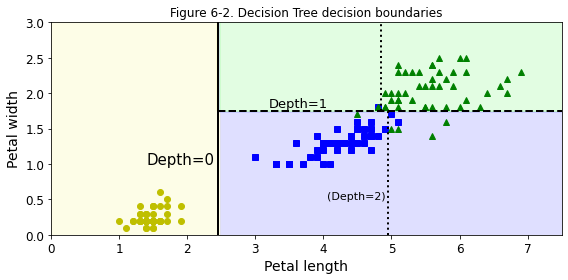

In [6]:
from matplotlib.colors import ListedColormap # 设置颜色

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):# 绘制决定边界的图像
    x1s = np.linspace(axes[0], axes[1], 100)# 设置边界
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)# 得到网格
    X_new = np.c_[x1.ravel(), x2.ravel()]# 网格降为一维，按行连接
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])# 颜色设置
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)# 绘制决策边界
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)
plt.title('Figure 6-2. Decision Tree decision boundaries')# 绘制题目

save_fig("decision_tree_decision_boundaries_plot")# 保存图片
plt.show()# 展示图片

Scikit-Learn使用的是CART算法，该算法只能生成二叉树：非叶节点永远只有两个子节点（即问题答案只有是/否）。但是，其他算法，比如ID3生成的决策树，它的节点可以拥有两个以上的子节点。
图6-2显示了决策树的决策边界。

* **粗垂直线**表示根节点（深度0）的决策边界：花瓣长度=2.45厘米。因为左侧区域是纯的（只有Setosa鸢尾花），所以它无法进一步拆分。 

* 但是右侧区域是不纯的，所以深度1的右侧节点在花瓣宽度= 1.75厘米处（**虚线**所示）再次分裂。因为这里最大深度max_depth设置为2，所以决策树在这里停止。 

* 但是，如果你将最大深度max_depth设置为3，那么两个深度为2的节点将各自再产生另一个决策边界（如**点线**所示）。

<center><big><b>模型解读：白盒与黑盒</b></big></center>

正如你所看到的，**决策树是非常直观的**，它们的决策也很容易解释。 这种模型通常被称为**白盒模型**。 与之相反的，正如我们稍后将要看到的，**随机森林或神经网络**通常被认为是**黑盒模型**。它们能够做出很好的预测，你也可以轻松检查它们做出这些预测时进行的计算；但是，通常很难用简单的术语来解释它们为什么做出这样的预测。例如，如果一个神经网络说某个人出现在一张图片上，很难知道它实际上是基于什么做出这样的预测：是模型识别出了这个人的眼睛？她的嘴巴？她的鼻子？她的鞋子？甚至是她坐的沙发？相反，决策树提供了简单好用的分类规则，如果需要的话，甚至可以手动应用这些规则（例如，花的分类）。

### 6.3 Estimating Class Probabilities—估算类别概率

决策树也可以估计某个实例属于特定类别 k 的概率：首先，跟随决策树找到该实例的叶节点，然后返回该节点中类别 k 的训练实例**比例**。
例如，如果你发现了一朵花，它的花瓣长5厘米，宽1.5厘米。 相应的叶节点是深度2的左侧节点，因此决策树输出如下概率：
* Iris-Setosa 为 0％（0/54），
* Iris-Versicolor 为 90.7％（49/54），
* Iris-Virginica 为 9.3％（5/54）。

当然，如果你要求它预测类别，它应该输出Versicolor鸢尾花（类别1），因为它的概率最高。让我们来检查一下：

In [29]:
tree_clf.predict_proba([[5,1.5]])# 获得可能情况的预测结果

array([[0.        , 0.90740741, 0.09259259]])

In [30]:
tree_clf.predict([[5,1.5]])（）# 获得预测结果

array([1])

完美！注意，在图6-2的右下角矩形中，任意点的估算概率都是相同的--比如，如果花瓣长6厘米，宽1.5厘米（虽然看起来在这种情况下，最可能是Virginica鸢尾花）。

### 6.4 The CART Training Algorithm—CART训练算法

Scikit-Learn使用**分类与回归树（Classification And Regression Tree-CART简称（CART））**算法来训练决策树（也叫做“生长”树）。 
想法非常简单：
首先使用**单个特征 k 和阈值 $t_k$** （例如，“花瓣长度≤2.45cm”）将训练集**分成两个子集**。 k 和 $t_k$怎么选择呢呢？答案是产生出最纯子集（按其大小加权）的k 和 $t_k$就是经算法搜索确定的$(k，t_k)$ 。算法尝试最小化的成本函数为公式6-2： 

<b>公式6-2</b> 

$J\left(k, t_{k}\right)=\frac{m_{\mathrm{left}}}{m} G_{\mathrm{left}}+\frac{m_{\mathrm{right}}}{m} G_{\mathrm{right}}$ 

公式6-2中 

* $G_{\text {left } / \text { right }}$测量左/右子集的不纯度。
* $m_{1 \mathrm{eft} / \mathrm{right}}$是左/右子集的实例数。


* 一旦成功地将训练集分成两部分，它就会**使用相同的逻辑**继续分裂子集，然后是子集的子集，依次循环递进。
* 直到达到**最大深度**（由超参数max_depth定义），或者是再也找不到能够降低不纯度的分裂，它才会停止。
* 还有一些超参数（稍后描述）可以用来控制其他的停止条件（min_samples_split，min_sam ples_leaf，min_weight_fraction_leaf和max_leaf_nodes）。

如你所见，CART算法是一种贪婪算法：它贪婪地从顶层开始搜索最佳分裂，然后在每层都重复这个过程。 几层分裂后，它并不会检查这个分裂的不纯度是否为可能的最低值。 贪心算法通常会产生一个**相当不错的解**，**但它不能保证是最优解**。 

而不幸的是，寻找最佳树是一个已知的**NP完全问题**：需要$O(exp(m))$时间，所以即使对于相当小的训练集，问题也很棘手。这就是为什么我们必须接受一个“合理的不错的”的解。

### 6.5 Computational Complexity—计算复杂度

进行预测需要从根到叶遍历决策树。通常来说，决策树大致平衡，因此遍历决策树需要经过大约$O(log_2(m))$个节点。因为每个节点仅需要检查一个特征值，所以总体预测复杂度也只是$O(log_2(m))$，与特征数量无关。 因此，即使是处理大型训练集，预测也非常快。

但是，训练时在每一个节点，算法都需要在所有样本上比较所有特征（如果设置了max_features会少一点）。 这导致训练的复杂度为$O(n×m log(m))。
* 对于小型训练集（几千个实例以内），Scikit-Learn可以通过*对数据预处理**（设置presort = True）来加速训练，
* 但是对于较大的训练集来说，可能会减慢训练速度。

### 6.6 Gini Impurity or Entropy?—基尼不纯度还是信息熵

默认情况下，使用基尼不纯度来进行测量，但是你可以通过将标准超参数“criterion”设置为“entropy”来选择信息熵作为不纯度的测量方式。熵的概念起源于热力学，是一种分子混乱程度的度量：
如果分子保持静止或者有序状态，则熵接近于零。 后来这个概念传播到各种领域，其中包括香农的信息理论，它测量的是一条消息的平均信息内容：如果所有的消息都相同，则熵为零。 在机器学习中，它也经常被用作一种不纯度的测量方式：如果一个集合只包含一个类别的实例，集合的熵为零。 公式6-3显示了第i个节点的熵值的计算方式。 例如，图6-1中的深度2的左侧节点的熵值等于$-\frac{49}{54}log(\frac{49}{54})-\frac{5}{54}log(\frac{5}{54})≈0.31$。

<b>公式6-3</b>  

$H_{i}=-\sum_{k=1 \atop p_{i, k} \neq 0}^{n} p_{i, k} \log _{2}\left(p_{i, k}\right)$

那么你到底应该使用基尼不纯度还是信息熵呢？ 其实，大多数情况下,它们之间没有什么大的不同：它们产生的树都很类似。基尼不纯度的计算速度稍微快一点，因此它是一个不错的默认选择。 它们不同在于，基尼不纯度倾向于从书中分裂出最常见的类别，而信息熵则倾向于生成更平衡的树。

### 6.7 Regularization Hyperparameters—正则化超参数

决策树很少对训练数据做出的假设（比如线性模型就正好相反，它显然假设数据是线性的）。如果不加以限制，树结构将跟随训练集变化，严密拟合，并且很可能过度拟合。 这种模型通常被称为**非参数模型**，这不是它不包含任何参数（它通常有很多），**而是指训练之前没有确定参数的向量**，所以模型结构可以自由地贴近数据。 相比之下，诸如线性模型的参数模型则有预先设定好的的一部分参数，因此其自由度受到限制，从而降低了过度拟合的风险（但增加了拟合不足的风险）。

为了避免过度拟合，你需要在训练期间**限制决策树的自由度**。 如你所知，这被称为**正则化**。正则化超参数的选择取决于所使用的算法，但通常你至少可以**限制决策树的最大深度**。 在Scikit-Learn中，这由**超参数max_depth**控制（默认值为None，意味着无限制）。**减少max_depth可以使模型正则化，从而降低过度拟合的风险**。

**DecisionTreeClassifier类**还有一些其他的参数，同样可以限制决策树的形状：

* min_samples_split（分裂前节点必须具有的最小样本数），

* min_samples_leaf（叶节点必须有的最小样本数量），

* min_weight_fraction_leaf（与min_samples_leaf相同，但表现为加权实例总数的占比），

* max_leaf_nodes（叶节点的最大数量），

* max_features（分裂每个节点评估的最大特征数量）。

* 增大超参数$\min _{-}^{*}$ 或者减小超参数 $\max _{-}^{*}$ 将使模型正则化。

还可以先在没有限制的情况下训练决策树，然后修剪（删除）不必要的节点。如果一个节点的子节点都是叶节点，这个节点可以被认为是不必要的，除非它所表示的纯度提升由衷的统计意义。标准统计检验，例如$χ^2$ 检验，是用来估算“提升纯粹是偶然结果”（被称为虚假设）的概率。如果这个概率（称之为p值）高于一个给定阈值（通常为5％，由超参数控制），那么该节点可以被认为是不必要的，其子节点可以被删除。直到所有不必要的节点都被删除，剪枝过程结束。

Saving figure min_samples_leaf_plot


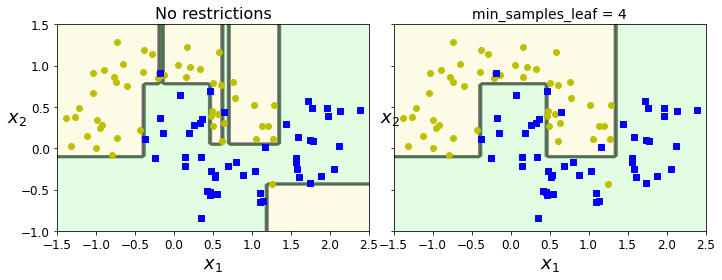

In [10]:
from sklearn.datasets import make_moons # 半环形数据集
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)  #生成半环形数据集

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)# 决策树分类
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)# 设定叶子节点最少样本后，进行决策树分类
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])# 绘制第一棵决策树的决策边界
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)# 画出决策边界
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])# 绘制第二棵决策树的决策边界
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)# 画出决策边界
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)# 绘制标题

save_fig("min_samples_leaf_plot")# 保存图片
plt.show()# 展示图片

图6-3(即上图)显示了在moons datasets （在第5章介绍）上训练的两个决策树。在左侧，使用默认超参数（即没有限制）训练决策树，在右侧，使用min_samples_leaf = 4训练决策树。很明显，左边的模型是过拟合的，右边的模型可能会泛化得更好。

### 6.8 Regression—回归

决策树还能够执行回归任务。让我们使用Scikit-Learn的**DecisionTreeRegressor**构建一个回归树，在一个有噪声的二次数据集上训练它，其中max_depth = 2

In [6]:
# 二次方训练集+噪音
np.random.seed(42) # 以使本笔记本的输出在不同的运行中保持稳定。
m = 200
X = np.random.rand(m, 1)# 返回一组200×1的服从“0~1”均匀分布的随机样本值。
y = 4 * (X - 0.5) ** 2 # 获得二次方训练集
y = y + np.random.randn(m, 1) / 10 # 在训练集上加上噪声

In [7]:
from sklearn.tree import DecisionTreeRegressor # 导入回归决策树

tree_reg = DecisionTreeRegressor(max_depth=2) # 设置决策树最大深度
tree_reg.fit(X,y) # 使用决策树进行训练

DecisionTreeRegressor(max_depth=2)

In [8]:
# 输出图形定义文件
export_graphviz(
        tree_reg,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

**你的第二个决策树长这样**
![image-20200721092447379](https://cdn.jsdelivr.net/gh/sadggdsa/typora-plugins-win-img@master/typora202007/21/092448-562604.png)

这棵树看起来与你之前构建的分类树非常相似。主要区别在于，每个节点上不再是预测**一个类别**，而是预测**一个值**。例如，如果你想要对$x_1 = 0.6$的新实例进行预测。 那么从根节点开始遍历树，最终到达预测值predicts value = 0.1106 的叶节点。 这个预测结果其实就是与这个叶节点相关联的110个训练实例的**平均目标值**。 在这110个实例上，预测产生的均方误差（MSE）等于0.0151。

在图6-5的左侧显示了模型的预测。如果设置max_depth = 3，将会获得如右侧所示的预测。注意看，每个区域的预测值始终是该区域中实例的**平均目标值**。算法分裂每个区域的方法，就是使最多的训练实例尽可能接近这个预测值。

Saving figure tree_regression_plot


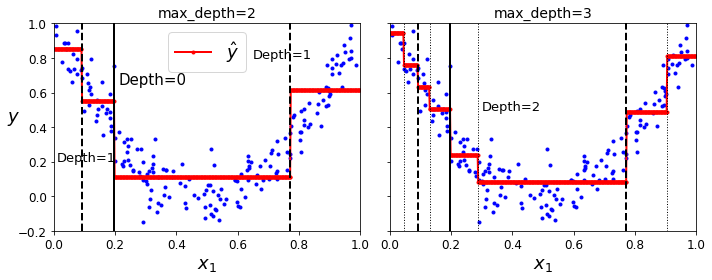

In [21]:
from sklearn.tree import DecisionTreeRegressor # 导入回归决策树
# 设置回归决策树的max_depth=2
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
# 设置回归决策树的max_depth=3
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):# 绘制回归预测
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)# 进行预测
    plt.axis(axes) # 绘制坐标轴
    plt.xlabel("$x_1$", fontsize=18)# 绘制横坐标
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)    

# 画出第一个回归决策树的预测和决策边界
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)


# 画出第二个回归决策树的预测和决策边界
plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")# 保存图片
plt.show()# 展示图片

CART算法的工作原理与前面介绍的大致相同，唯一不同在于，它分裂训练集的方式不是最小化**不纯度**，而是最小化**MSE**。公式6-4显示了算法尝试最小化的成本函数。

<b>公式6-4</b>
 
$J\left(k, t_{k}\right)=\frac{m_{\mathrm{left}}}{m} \mathrm{MSE}_{\mathrm{left}}+\frac{m_{\mathrm{right}}}{m} \mathrm{MSE}_{\mathrm{right}}$ 
 

<b>公式6-4中</b> 

* $\mathrm{MSE}_{\text {node }}=\sum_{i \in \text { node }}\left(\hat{y}_{\text {node }}-y^{(i)}\right)^{2}$
* $\hat{y}_{\text {node }}=\frac{1}{m_{\text {node }} i \in \text { node }} y^{(i)}$

Saving figure tree_regression_regularization_plot


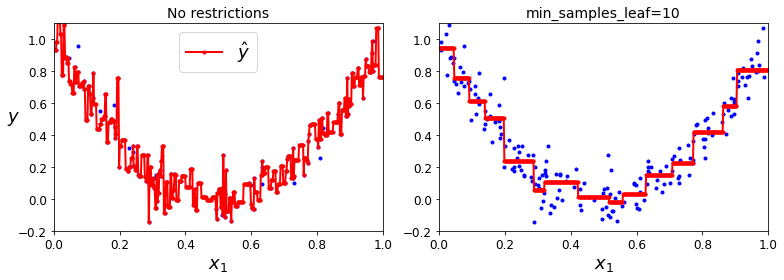

In [22]:
tree_reg1 = DecisionTreeRegressor(random_state=42)# 默认的回归决策树
# 设置min_samples_leaf=10的回归决策树
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)
# 进行预测
x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))
# 画出第一个回归决策树的预测
plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)
# 画出第二个回归决策树的预测
plt.subplot(122)
plt.plot(X, y, "b.")# 绘制数据点
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")# 绘制预测点
plt.axis([0, 1, -0.2, 1.1])# 绘制坐标轴
plt.xlabel("$x_1$", fontsize=18)# 绘制横坐标
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)# 绘制标题

save_fig("tree_regression_regularization_plot")# 保存图片
plt.show()# 展示图片

就像**分类任务**一样,决策树在处理**回归任务**时也很容易过度拟合。如果没有任何正则化（即使用默认的超参数），你将获得如图6-6左侧所示的预测结果。
这显然对训练集严重过度拟合。只需要设置**min_samples_leaf = 10**，就能够得到一个看起来合理得多的模型，如图6-6右侧所示。

### 6.9 Instability—不稳定性

Saving figure sensitivity_to_rotation_plot


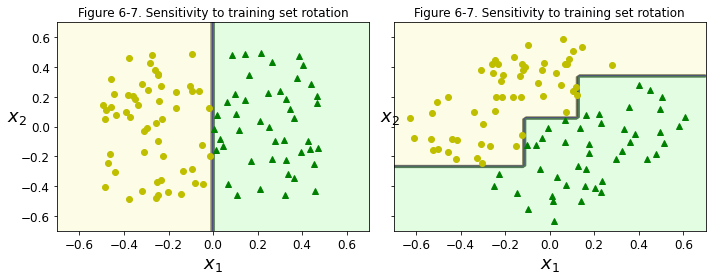

In [23]:
np.random.seed(6)# # 以使本笔记本的输出在不同的运行中保持稳定。
Xs = np.random.rand(100, 2) - 0.5# 返回一组100×2的服从“0~1”均匀分布的随机样本值。
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
# 生成矩阵和点乘后的矩阵
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)
# 使用决策树进行分类
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)
# 画出第一个决策树的边界
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.title('Figure 6-7. Sensitivity to training set rotation')
# 画出第二个决策树的边界
plt.sca(axes[1])
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.title('Figure 6-7. Sensitivity to training set rotation')# 绘制标题

save_fig("sensitivity_to_rotation_plot")# 保存图片
plt.show()# 展示图片

希望现在，你已经确信了选择决策树有充足的理由：它们很容易理解和解释，使用简单，功能多样，功能全面并且十分强大。但是它们确实也有一些限制。

1. 首先，正如你可能已经注意到的，决策树青睐正交的决策边界（所有分裂都与轴线垂直），这导致它们**对训练集的旋转**非常敏感。例如，图6-7显示了一个简单的线性可分离数据集：
   * 在左侧，决策树可以轻分裂，
   * 在右侧，数据集旋转45°后，决策边界看起来产生了不必要的卷曲。
   
   尽管两个决策树看起来都完美地拟合训练集，但是右侧的模型很可能泛化不佳。 限制这种问题的方法之一是使用PCA（参见第8章），让训练数据定位在一个更好的方向上。

2. 更概括地说，决策树的主要问题是它们对训练数据中的微小变化非常敏感。例如，如果你只是从鸢尾花训练集中移除最宽的Versicolor鸢尾花（花瓣长4.8厘米，宽1.8厘米），然后重新训练一个新的决策树，你可能得到如图6-8所示的模型。这跟之前6-2的决策树看起来完全不同。事实上，由于Scikit-Learn使用的训练算法是随机的，即使在相同的训练数据上，你也可能得到完全不同的模型（除非你对random_state超参数进行了设置）。

Saving figure tree_regression_regularization_plot


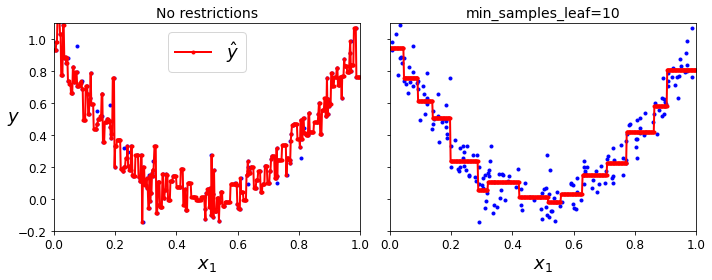

In [24]:
tree_reg1 = DecisionTreeRegressor(random_state=42)# 设置random_state超参数
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)# 设置random_state和min_samples_leaf
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)# 进行预测
y_pred2 = tree_reg2.predict(x1)# 进行预测

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# 绘制第一个决策树的预测
plt.sca(axes[0])
plt.plot(X, y, "b.")# 绘制数据点
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")# 绘制预测点
plt.axis([0, 1, -0.2, 1.1])# 绘制坐标轴
plt.xlabel("$x_1$", fontsize=18)# 绘制横坐标
plt.ylabel("$y$", fontsize=18, rotation=0)# 绘制纵坐标
plt.legend(loc="upper center", fontsize=18)# 绘制图例
plt.title("No restrictions", fontsize=14)# 回执表其
# 绘制第二个回归树的预测
plt.sca(axes[1])
plt.plot(X, y, "b.")# 绘制数据点
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")# 绘制预测点
plt.axis([0, 1, -0.2, 1.1])# 绘制坐标轴
plt.xlabel("$x_1$", fontsize=18)# 绘制横坐标
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)# 绘制标题

save_fig("tree_regression_regularization_plot")# 保存图片
plt.show()# 展示图片